In [1]:
import sys, os, time
sys.path.append('../..')
import pyzx as zx
from benchmarking import Benchmark

The ``Benchmark`` class provides a convenient wrapper in order to compare different circuit optimisation methods. To use it, we first create our benchmark object. 

If a previous object has been saved (using ``Benchmark.save('dirpath')``), we can load this directly from the directory.

In [2]:
b = Benchmark()
# b = Benchmark(dirpath='benchmarking_demo_results')

We can then load the set of circuits which we want to benchmark. 

If we have a set of already optimised circuits via a different routine, we can also load these. 

Here we load sets of optimised circuits by the following two routines:

* NRSCM - [Nam, Ross, Su, Childs, Maslov - Automated optimization of large quantum circuits with continuous parameters](https://www.nature.com/articles/s41534-018-0072-4).
* TPar - [Amy, Maslov, Mosca - Polynomial-time T-depth Optimization of Clifford+T circuits via Matroid Partitioning](https://arxiv.org/abs/1303.2042)

In [3]:
b.load_circuits(dirname=os.path.join('..', '..', 'circuits', 'benchmarking_circuits', 'Fast', 'before'), group_name='fast')
b.load_circuits(dirname=os.path.join('..', '..', 'circuits', 'benchmarking_circuits', 'Fast', 'nrscm'), group_name='fast', simp_strategy='NRSCM')
b.load_circuits(dirname=os.path.join('..', '..', 'circuits', 'benchmarking_circuits', 'Fast', 'tpar'), group_name='fast', simp_strategy='TPar')
b.show_attributes()

Circuit attributes:  ['Qubits', 'Gates', '2Q Count', 'T Count', 't_opt']
No loaded functions
Loaded routines:  ['TPar', 'NRSCM']
Loaded circuit groups:  ['fast']


,Original,NRSCM,TPar
fast,Y,Y,Y


We can then define the optimisation functions which we want to benchmark. These should take a circuit as input and output the optimised circuit.

In [4]:
def basic_optimise(c):
    c1 = zx.basic_optimization(c.copy(), do_swaps=False).to_basic_gates()
    c2 = zx.basic_optimization(c.copy(), do_swaps=True).to_basic_gates()
    if c2.twoqubitcount() < c1.twoqubitcount(): return c2 # As this optimisation algorithm is targetted at reducting H-gates, we use the circuit with the smaller 2-qubit gate count here, either using SWAP rules or not.
    return c1

def clifford_simp(c):
    g = c.to_graph()
    zx.clifford_simp(g, quiet=True)
    c2 = zx.extract_circuit(g).to_basic_gates()
    return basic_optimise(c2)

def full_reduce(c):
    g = c.to_graph()
    zx.full_reduce(g, quiet=True)
    c2 = zx.extract_circuit(g).to_basic_gates()
    return basic_optimise(c2)

def flow_opt(c):
    g = c.to_graph()
    zx.teleport_reduce(g)
    zx.to_graph_like(g)
    zx.flow_2Q_simp(g)
    c2 = zx.extract_simple(g).to_basic_gates()
    return basic_optimise(c2)

These functions can then be added to the benchmark object. If desired they can also be deleted using ``b.del_simplification_funcs(['func'])``.

They can either be run immediately on a group of circuits (default is all), or run afterwards.

The optimised circuits can optionally be verified to equal the original circuit (by using full_reduce on the original + adjoint).

In [5]:
b.add_simplification_func(func=full_reduce, name='full-reduce', groups_to_run=['fast'], verify=True, rerun=False)
b.add_simplification_func(func=clifford_simp, name='cliff-simp', groups_to_run=['fast'], verify=True, rerun=False)

b.add_simplification_func(func=flow_opt, name='flow-opt', groups_to_run=None)
b.run(funcs_to_run=['flow-opt'], groups_to_run=['fast'], verify=True, rerun=False)

b.show_attributes()

Processing full-reduce on tof_3                                       :   0%|          | 0/31 [00:00<?, ?it/s]

Processing full-reduce on qft_4                                       : 100%|██████████| 31/31 [00:17<00:00,  1.73it/s]
Processing cliff-simp on qft_4                                        : 100%|██████████| 31/31 [00:08<00:00,  3.55it/s]
Processing flow-opt on qft_4                                          : 100%|██████████| 31/31 [00:28<00:00,  1.07it/s]

Circuit attributes:  ['Qubits', 'Gates', '2Q Count', 'T Count', 't_opt']
Loaded functions:  ['full-reduce', 'cliff-simp', 'flow-opt']
Loaded routines:  ['TPar', 'NRSCM']
Loaded circuit groups:  ['fast']


,Original,NRSCM,TPar,cliff-simp,flow-opt,full-reduce
fast,Y,Y,Y,Y,Y,Y


You can then view the results in a dataframe.

In [6]:
df = b.df(groups=['fast'], routines=['all'], funcs=['all'], atts=['Qubits','2Q Count','T Count', 't_opt'])

You can also generate graphs based on optimisations of randomly generated circuits.

Processing flow-opt on P_t = 0.15                 : 100%|██████████| 11/11 [00:47<00:00,  4.35s/it]


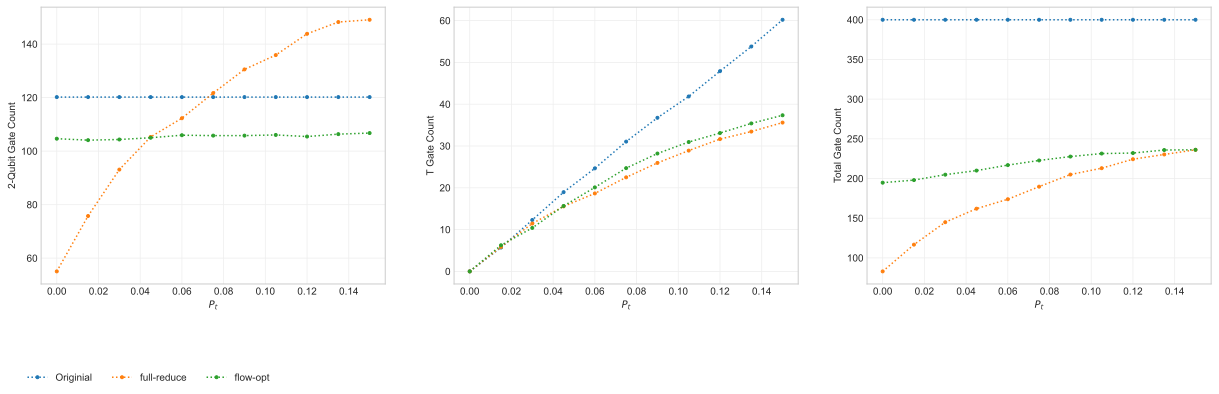

In [7]:
fig = b.Pt_graphs(funcs=['full-reduce', 'flow-opt'], qubits=8, depth=400, cnot_prob=0.3, t_probs=[0.015*i for i in range(11)], ys=['2Q Count', 'T Count', 'Gates'], reps=20, overwrite=True, random_seed=42)

In [8]:
# b.save('benchmarking_demo_results')